<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLatFIAN2020/blob/master/seminar12/MLatFIAN2020_seminar12_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN example

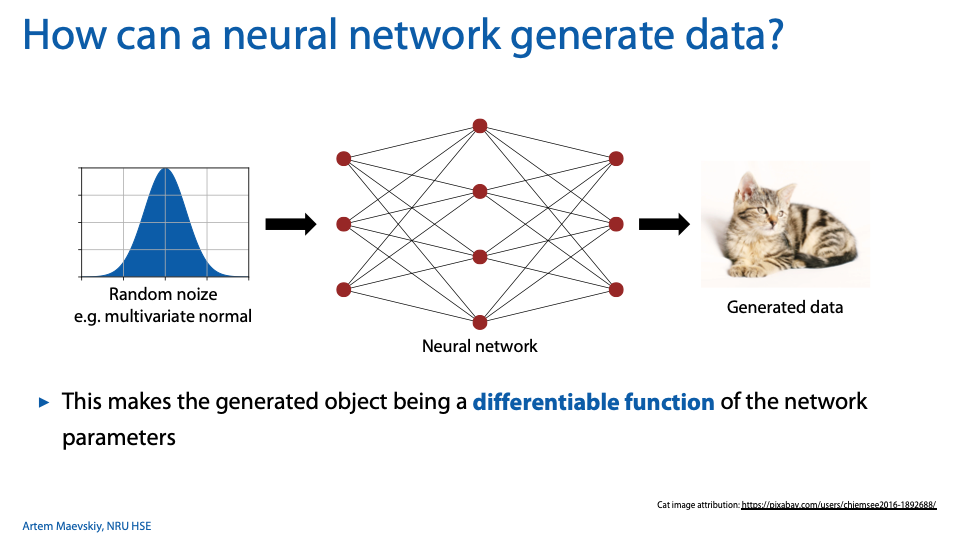

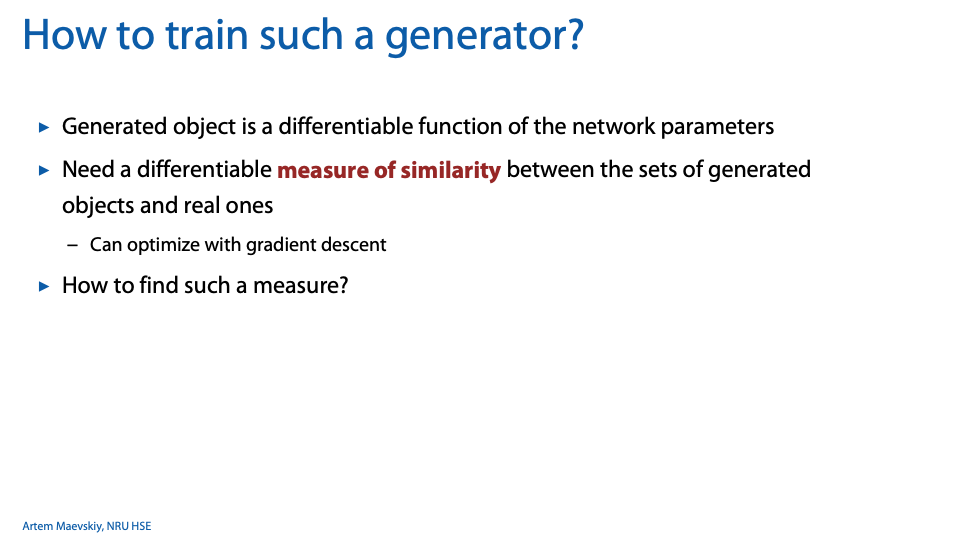

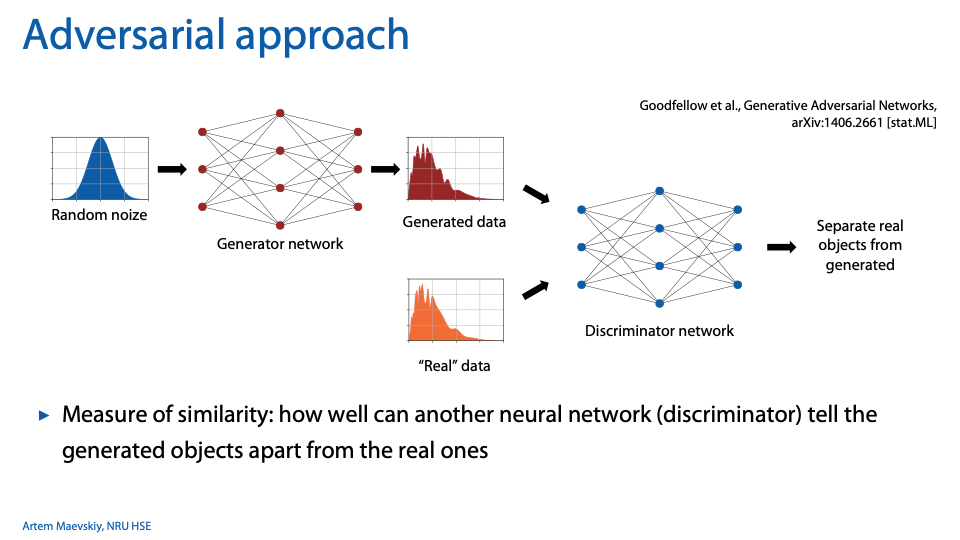

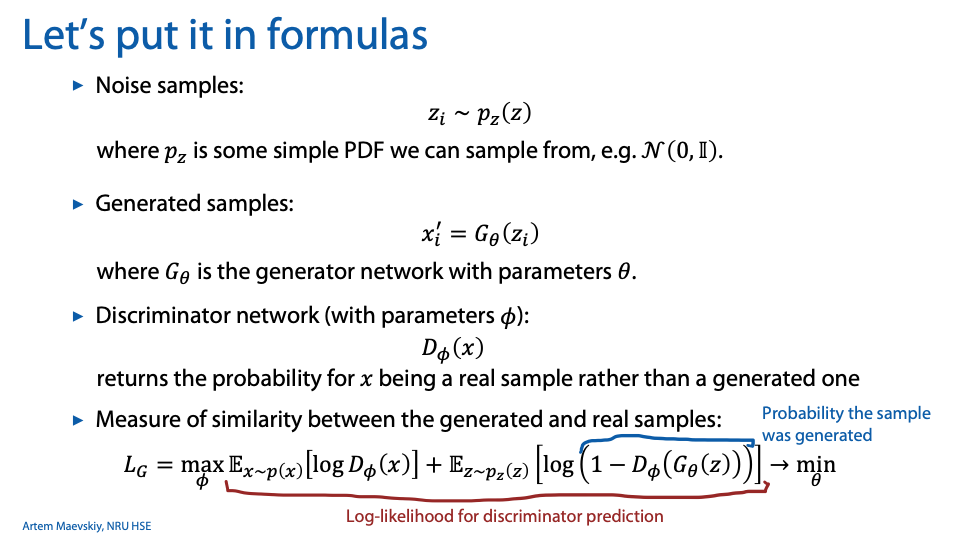

Today we'll try to generate people's faces.
As always, let's start with the imports:

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
from tqdm import tqdm

from PIL import Image

2.3.0


And now we'll get the dataset:

In [2]:
lfw = tfds.image_classification.LFW()
lfw.download_and_prepare()
ds = lfw.as_dataset()

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteG2HLEA/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


Original images are a bit too large for this exercise - we want to keep it lightweight (although feel free to try different image sizes later if you want).

In [3]:
def get_img(x):
  return x['image'][80:-80,80:-80]

data = np.array([
  np.array(Image.fromarray(img.numpy()).resize((36, 36)))
  for img in tqdm(ds['train'].map(get_img))
])

100%|██████████| 13233/13233 [00:13<00:00, 1004.07it/s]


Let's have a look at the result:

In [4]:
data.shape

(13233, 36, 36, 3)

In [5]:
import matplotlib.pyplot as plt

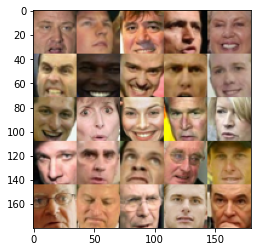

In [6]:
plt.imshow(data[:25].reshape(5, 5, 36, 36, 3).transpose((0, 2, 1, 3, 4)).reshape(5 * 36, 5 * 36, 3));

Ok, now let's build our GAN!

First we'll preprocess the data:

In [7]:
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

0.0 1.0 float32


Defining the architecture. 

In [ ]:
ll = tf.keras.layers

LATENT_DIM = 32

# For simplicity, let's first define our networks as fully-connectd
generator = tf.keras.Sequential([
  <YOUR CODE>
])

discriminator = tf.keras.Sequential([
  <YOUR CODE>
])

generator.summary()
discriminator.summary()

For the discriminator, we'll use the regular cross-entropy (a.k.a. negative log-likelihood) loss:
$$L=-\left[\mathbb{E}_{x\sim p_{data}}\log D(x)+\mathbb{E}_{x\sim p_{gen}}\log(1 - D(x))\right].$$

Note, that to re-use the predifined `tf.nn.sigmoid_cross_entropy_with_logits` loss function:
$$l(y, D(x))=-\left[\mathbb{I}(y=1)\cdot\log\sigma(D(x)) + \mathbb{I}(y=0)\cdot\log(1-\sigma(D(x)))\right],$$
it is useful to introduce targets $y=0$ for the generated objects and $y=1$ for the real ones.

Here we'll define our loss functions and optimization steps:

In [ ]:
def gen_images(num):
  return generator(tf.random.normal(shape=(num, LATENT_DIM)))

# @tf.function decorator below compiles the function
# it decorates into a static graph. This improves the performance
# but there are some pitfalls one should be aware of when using it,
# check out https://www.tensorflow.org/guide/function
# for more details
@tf.function
def forward(batch):
  real = batch
  fake = gen_images(len(batch))

  # calculate the loss function value for the discriminator
  # using tf.nn.sigmoid_cross_entropy_with_logits
  <YOUR CODE>
  loss = <YOUR CODE>
  return loss

opt_d = tf.optimizers.RMSprop()
opt_g = tf.optimizers.RMSprop()

@tf.function
def disc_step(batch):
  with tf.GradientTape() as t:
    d_loss = forward(batch)
  grads = t.gradient(d_loss, discriminator.trainable_variables)
  opt_d.apply_gradients(zip(grads, discriminator.trainable_variables))
  return d_loss

@tf.function
def gen_step(batch):
  with tf.GradientTape() as t:
    g_loss = -forward(batch)
  grads = t.gradient(g_loss, generator.trainable_variables)
  opt_g.apply_gradients(zip(grads, generator.trainable_variables))
  return g_loss

Finally, let's write our training loop:

In [ ]:
from IPython.display import clear_output
from tqdm import trange

In [ ]:
BATCH_SIZE = 256

N_EPOCHS = 100
NUM_DISC_STEPS = 5

i_disc_step = 0
losses_gen = []
losses_disc = []
for i_ep in range(N_EPOCHS):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
  epoch_loss_gen = []
  epoch_loss_disc = []
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]

    if i_disc_step < NUM_DISC_STEPS:
      # discriminator update
      i_disc_step += 1
      epoch_loss_disc.append(disc_step(batch).numpy())
    else:
      # generator update
      i_disc_step = 0
      epoch_loss_gen.append(gen_step(batch).numpy())

  losses_gen.append(np.mean(epoch_loss_gen))
  losses_disc.append(np.mean(epoch_loss_disc))

  opt_d.learning_rate.assign(opt_d.learning_rate * 0.99)
  opt_g.learning_rate.assign(opt_g.learning_rate * 0.99)

  imgs = (gen_images(25).numpy() * 255).astype('uint8')
  clear_output(wait=True)
  plt.figure(figsize=(12, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
  plt.subplot(1, 2, 2)
  plt.plot(losses_gen, label='generator')
  plt.plot(losses_disc, label='discriminator')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print("Done with epoch #", i_ep)

## Exercises

### 1. More stable loss

Modify the generator loss to a more stable form, i.e. instead of minimizing
$$
\mathscr{L}_{\text{gen}}=\mathbb{E}_{z\sim p_z(z)}\log\left(1-D(G(z))\right),
$$
which is unbound from below, minimize:
$$
\mathscr{L}_{\text{gen}}=-\mathbb{E}_{z\sim p_z(z)}\log\left(D(G(z))\right)
$$

N.B. In the code above we didn't write all this explicitly. Instead we used `tf.nn.sigmoid_cross_entropy_with_logits` that contains these expressions inside. Can you achieve the above modification by just modifying the inputs to `tf.nn.sigmoid_cross_entropy_with_logits` somehow?

### 2. Implement a GAN with convolutional architecture

Feel free to re-use the code above.

### 3. Implement a Wasserstein GAN with gradient penalty term

https://arxiv.org/abs/1704.00028

In particular:

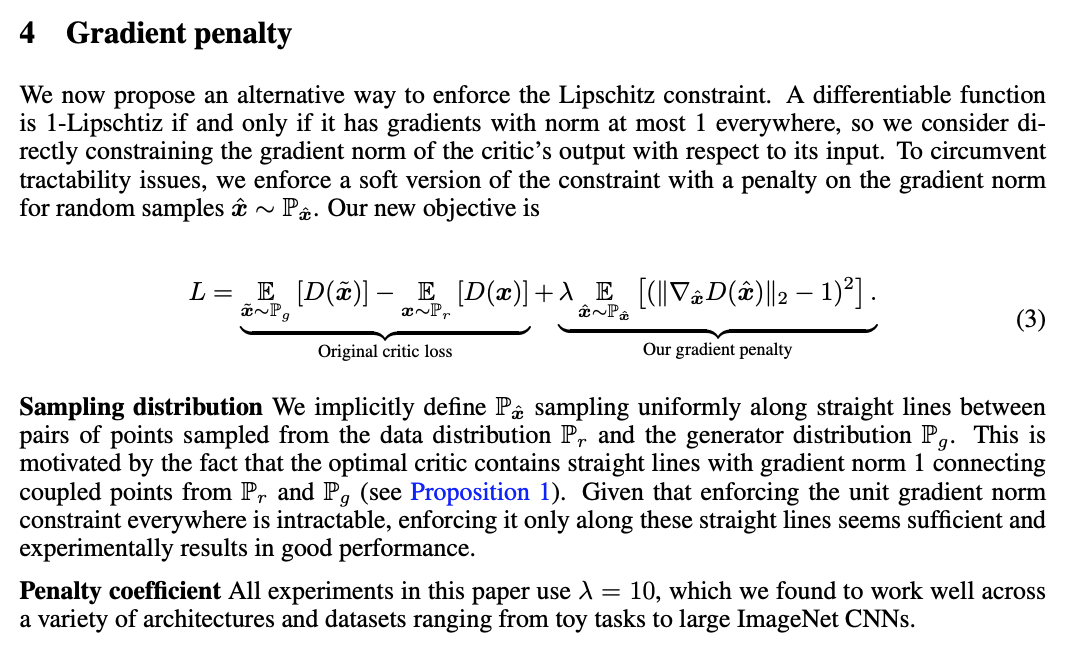

Again, feel free to reuse the code above where applicable.